# 🗑️ Trash-Buddy Model Evaluation & Analysis

## Overview
This notebook handles the fourth step of the Trash-Buddy pipeline: **Model Evaluation & Analysis**. After training from Step 3, we perform:

- Comprehensive performance analysis
- Error analysis and misclassification patterns
- Per-class and per-category performance evaluation
- Model interpretability and visualization
- Recommendations for model improvement

---

## 📊 Prerequisites from Step 3

From the training step, we have:
- **Trained model** saved as checkpoint
- **Training history** with epoch-by-epoch metrics
- **Evaluation results** on test set
- **Confusion matrix** data
- **Per-class metrics** (F1-scores, precision, recall)

---

## 🎯 Objectives
1. Load trained model and evaluation results
2. Analyze overall model performance
3. Identify misclassification patterns
4. Evaluate per-class and per-category performance
5. Visualize model predictions and errors
6. Generate recommendations for improvement


In [2]:
# Import necessary libraries
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


## 📁 Load Model and Evaluation Results

Load the trained model, evaluation results, and necessary data.


In [3]:
# Define paths
models_dir = Path('models')
processed_data_dir = Path('processed_data')
data_dir = Path('Data')

# Load evaluation results
with open(models_dir /'evaluation_results.json','r') as f:
 eval_results = json.load(f)

# Load training history
training_history = pd.read_csv(models_dir /'training_history.csv')

# Load test split
df_test = pd.read_csv(processed_data_dir /'test_split.csv')

# Load label classes
label_classes = np.load(processed_data_dir /'label_classes.npy', allow_pickle=True)

# Create label encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes

print("=" * 80)
print("DATA LOADING")
print("=" * 80)
print(f"\n Evaluation results loaded")
print(f" Test Accuracy: {eval_results['test_accuracy']:.2f}%")
print(f" Test Weighted F1: {eval_results['test_f1_weighted']:.4f}")
print(f" Test Macro F1: {eval_results['test_f1_macro']:.4f}")

print(f"\n Training history loaded: {len(training_history)} epochs")
print(f"\n Test set loaded: {len(df_test):,} images")
print(f"\n Label classes loaded: {len(label_classes)} classes")


DATA LOADING

✅ Evaluation results loaded
   Test Accuracy: 75.85%
   Test Weighted F1: 0.7387
   Test Macro F1: 0.6956

✅ Training history loaded: 37 epochs

✅ Test set loaded: 1,619 images

✅ Label classes loaded: 18 classes


## 📊 Overall Performance Analysis

Analyze the overall model performance metrics.


In [4]:
# Overall metrics
print("=" * 80)
print("OVERALL MODEL PERFORMANCE")
print("=" * 80)

print(f"\n Test Set Metrics:")
print(f" Accuracy: {eval_results['test_accuracy']:.2f}%")
print(f" Loss: {eval_results['test_loss']:.4f}")
print(f" Weighted F1-Score: {eval_results['test_f1_weighted']:.4f}")
print(f" Macro F1-Score: {eval_results['test_f1_macro']:.4f}")

print(f"\n Training Summary:")
print(f" Best Validation Accuracy: {eval_results['best_val_acc']:.2f}%")
print(f" Best Validation Loss: {eval_results['best_val_loss']:.4f}")
print(f" Total Epochs Trained: {eval_results['total_epochs']}")

# Calculate accuracy gap
accuracy_gap = eval_results['best_val_acc'] - eval_results['test_accuracy']
print(f"\n Generalization Analysis:")
print(f" Validation → Test Accuracy Gap: {accuracy_gap:.2f}%")
if abs(accuracy_gap) < 2:
 print(" Good generalization(gap < 2%)")
elif abs(accuracy_gap) < 5:
 print(" Moderate generalization gap(2-5%)")
else:
 print(" Large generalization gap(>5%) - possible overfitting")

# F1-score analysis
f1_gap = eval_results['test_f1_weighted'] - eval_results['test_f1_macro']
print(f"\n Weighted F1 - Macro F1 Gap: {f1_gap:.4f}")
if f1_gap < 0.05:
 print(" Balanced performance across classes")
else:
 print(" Performance varies significantly across classes")


OVERALL MODEL PERFORMANCE

📊 Test Set Metrics:
   Accuracy: 75.85%
   Loss: 1.3254
   Weighted F1-Score: 0.7387
   Macro F1-Score: 0.6956

📊 Training Summary:
   Best Validation Accuracy: 74.91%
   Best Validation Loss: 1.3137
   Total Epochs Trained: 37

📊 Generalization Analysis:
   Validation → Test Accuracy Gap: -0.94%
   ✅ Good generalization (gap < 2%)

   Weighted F1 - Macro F1 Gap: 0.0431
   ✅ Balanced performance across classes


## 📈 Training History Analysis

Visualize and analyze the training progress.


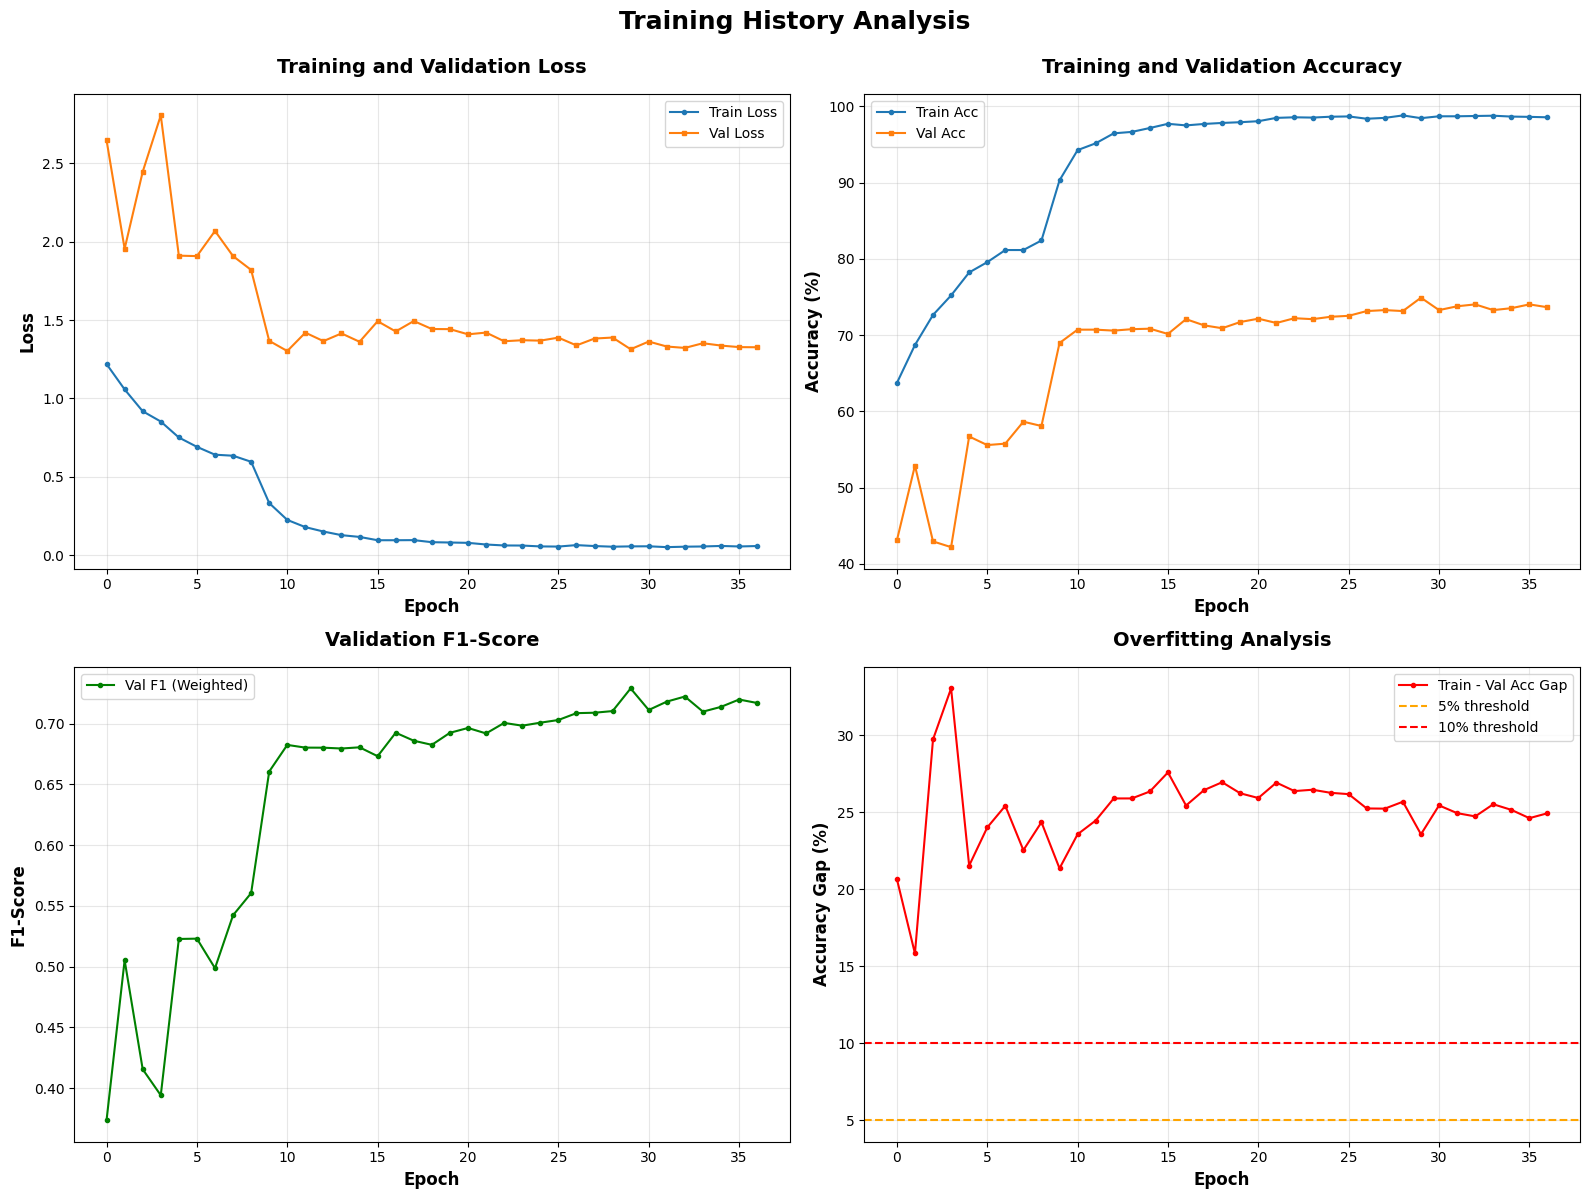


📊 Training History Analysis:
   Final Train Acc: 98.58%
   Final Val Acc: 73.65%
   Final Accuracy Gap: 24.92%
   Max Accuracy Gap: 33.03% (Epoch 4)
   Best Val Acc: 74.91% (Epoch 30)


In [5]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training History Analysis', fontsize=18, fontweight='bold', y=0.995)

# Loss plot
axes[0, 0].plot(training_history['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0, 0].plot(training_history['val_loss'], label='Val Loss', marker='s', markersize=3)
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=15)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(training_history['train_acc'], label='Train Acc', marker='o', markersize=3)
axes[0, 1].plot(training_history['val_acc'], label='Val Acc', marker='s', markersize=3)
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy(%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 score plot
axes[1, 0].plot(training_history['val_f1'], label='Val F1(Weighted)', marker='o', markersize=3, color='green')
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Validation F1-Score', fontsize=14, fontweight='bold', pad=15)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Overfitting analysis(train - val accuracy gap)
accuracy_gap = training_history['train_acc'] - training_history['val_acc']
axes[1, 1].plot(accuracy_gap, label='Train - Val Acc Gap', marker='o', markersize=3, color='red')
axes[1, 1].axhline(y=5, color='orange', linestyle='--', label='5% threshold')
axes[1, 1].axhline(y=10, color='red', linestyle='--', label='10% threshold')
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy Gap(%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Overfitting Analysis', fontsize=14, fontweight='bold', pad=15)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print analysis
print("\n Training History Analysis:")
print(f" Final Train Acc: {training_history['train_acc'].iloc[-1]:.2f}%")
print(f" Final Val Acc: {training_history['val_acc'].iloc[-1]:.2f}%")
print(f" Final Accuracy Gap: {accuracy_gap.iloc[-1]:.2f}%")
print(f" Max Accuracy Gap: {accuracy_gap.max():.2f}%(Epoch {accuracy_gap.idxmax() + 1})")
print(f" Best Val Acc: {training_history['val_acc'].max():.2f}%(Epoch {training_history['val_acc'].idxmax() + 1})")


## 🔍 Per-Class Performance Analysis

Analyze performance for each class to identify weak points.


In [6]:
# Load model for predictions(we'll need to recreate it)
# First, let's load the model checkpoint to get config
model_checkpoint_path = list(models_dir.glob('best_model_*.pth'))[0]
checkpoint = torch.load(model_checkpoint_path, map_location=device, weights_only=False)

# Get model config
model_config = checkpoint.get('config', {})
MODEL_NAME = model_config.get('MODEL_NAME','resnet50')
NUM_CLASSES = len(label_classes)

# Recreate model architecture(simplified - we'll load it properly later)
def create_model(model_name='resnet50', num_classes=18):
"""Create model architecture"""
 try:
 if model_name =='resnet50':
 weights = models.ResNet50_Weights.DEFAULT
 model = models.resnet50(weights=weights)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 weights = models.EfficientNet_B0_Weights.DEFAULT
 model = models.efficientnet_b0(weights=weights)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 weights = models.MobileNet_V2_Weights.DEFAULT
 model = models.mobilenet_v2(weights=weights)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 else:
 raise ValueError(f"Unknown model: {model_name}")
 except AttributeError:
 # Fallback for older versions
 if model_name =='resnet50':
 model = models.resnet50(pretrained=True)
 model.fc = nn.Linear(model.fc.in_features, num_classes)
 elif model_name =='efficientnet_b0':
 model = models.efficientnet_b0(pretrained=True)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 elif model_name =='mobilenet_v2':
 model = models.mobilenet_v2(pretrained=True)
 model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
 return model

# For now, we'll work with the evaluation results
# Extract per-class F1 scores
per_class_f1 = eval_results['per_class_f1']

# Create DataFrame for analysis
per_class_df = pd.DataFrame([
 {'Class': class_name,'F1_Score': f1}
 for class_name, f1 in per_class_f1.items()
])

# Sort by F1 score
per_class_df = per_class_df.sort_values('F1_Score')

# Add category information
per_class_df['Category'] = per_class_df['Class'].apply(
 lambda x: df_test[df_test['subcategory'] == x]['category'].iloc[0] if len(df_test[df_test['subcategory'] == x]) > 0 else'Unknown'
)

print("=" * 80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 80)

print(f"\n Per-Class F1-Scores(Sorted):")
print(f"{'Class':<30s} {'F1-Score':<12s} {'Category':<20s} {'Status'}")
print("-" * 80)
for _, row in per_class_df.iterrows():
 f1 = row['F1_Score']
 if f1 >= 0.8:
 status =" Excellent"
 elif f1 >= 0.6:
 status =" Good"
 elif f1 >= 0.4:
 status =" Fair"
 else:
 status =" Poor"
 print(f"{row['Class']:<30s} {f1:<12.4f} {row['Category']:<20s} {status}")

print(f"\n Performance Statistics:")
print(f" Mean F1-Score: {per_class_df['F1_Score'].mean():.4f}")
print(f" Median F1-Score: {per_class_df['F1_Score'].median():.4f}")
print(f" Std Dev: {per_class_df['F1_Score'].std():.4f}")
print(f" Min F1-Score: {per_class_df['F1_Score'].min():.4f}({per_class_df.loc[per_class_df['F1_Score'].idxmin(),'Class']})")
print(f" Max F1-Score: {per_class_df['F1_Score'].max():.4f}({per_class_df.loc[per_class_df['F1_Score'].idxmax(),'Class']})")


PER-CLASS PERFORMANCE ANALYSIS

📊 Per-Class F1-Scores (Sorted):
Class                          F1-Score     Category             Status
--------------------------------------------------------------------------------
kitchen_waste                  0.1231       Organic              ❌ Poor
sanitary_napkin                0.5238       Non-Recyclable       ⚠️ Fair
ceramic_product                0.5660       Non-Recyclable       ⚠️ Fair
platics_bags_wrappers          0.5660       Non-Recyclable       ⚠️ Fair
paints                         0.6333       Hazardous            ✅ Good
batteries                      0.6522       Hazardous            ✅ Good
pesticides                     0.7234       Hazardous            ✅ Good
diapers                        0.7273       Non-Recyclable       ✅ Good
food_scraps                    0.7534       Organic              ✅ Good
paper_products                 0.7547       Recyclable           ✅ Good
glass_containers               0.7692       Recyclable      

## 📊 Per-Class Performance Visualization

Visualize per-class performance metrics.


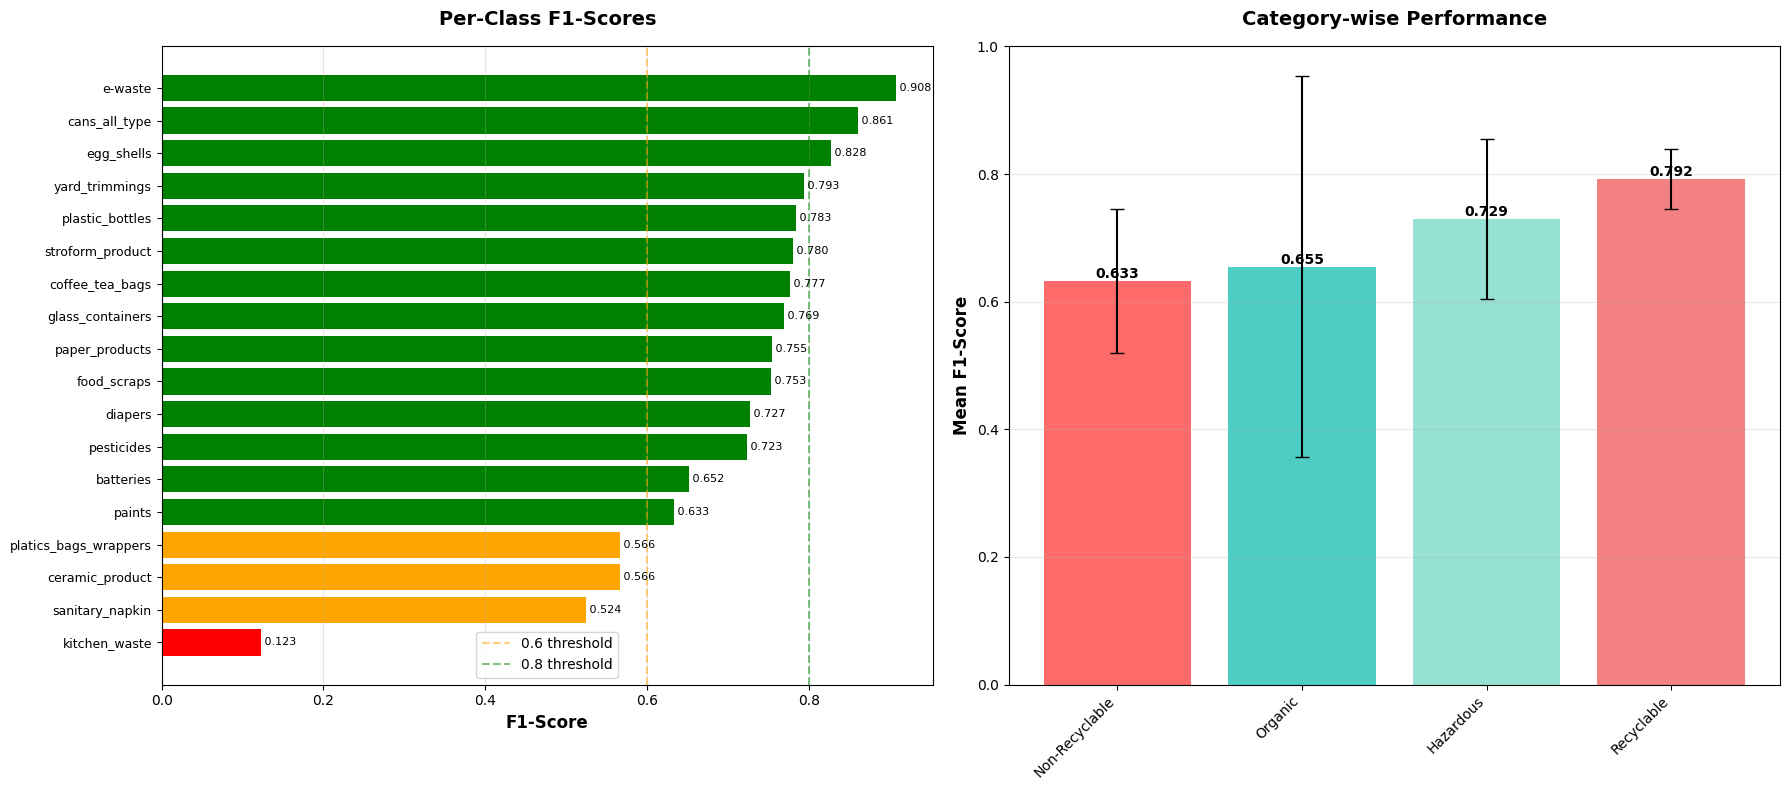

In [7]:
# Visualize per-class F1 scores
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar plot of F1 scores
ax1 = axes[0]
colors = ['red' if f1 < 0.4 else'orange' if f1 < 0.6 else'green' for f1 in per_class_df['F1_Score']]
bars = ax1.barh(range(len(per_class_df)), per_class_df['F1_Score'], color=colors)
ax1.set_yticks(range(len(per_class_df)))
ax1.set_yticklabels(per_class_df['Class'], fontsize=9)
ax1.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class F1-Scores', fontsize=14, fontweight='bold', pad=15)
ax1.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='0.6 threshold')
ax1.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='0.8 threshold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i,(bar, f1) in enumerate(zip(bars, per_class_df['F1_Score'])):
 ax1.text(f1, i, f' {f1:.3f}', va='center', fontsize=8)

# Category-wise performance
ax2 = axes[1]
category_performance = per_class_df.groupby('Category')['F1_Score'].agg(['mean','std','min','max'])
category_performance = category_performance.sort_values('mean')

x_pos = np.arange(len(category_performance))
bars = ax2.bar(x_pos, category_performance['mean'], 
 yerr=category_performance['std'],
 capsize=5, color=['#FF6B6B','#4ECDC4','#95E1D3','#F38181'])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(category_performance.index, rotation=45, ha='right')
ax2.set_ylabel('Mean F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Category-wise Performance', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i,(bar, mean_f1) in enumerate(zip(bars, category_performance['mean'])):
 ax2.text(bar.get_x() + bar.get_width()/2., mean_f1,
 f'{mean_f1:.3f}',
 ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## 🔍 Error Analysis

Analyze misclassifications and error patterns.


In [8]:
# Load model and make predictions for error analysis
print("=" * 80)
print("LOADING MODEL FOR ERROR ANALYSIS")
print("=" * 80)

# Load model checkpoint
model_checkpoint_path = list(models_dir.glob('best_model_*.pth'))[0]
checkpoint = torch.load(model_checkpoint_path, map_location=device, weights_only=False)

# Get model config
model_config = checkpoint.get('config', {})
MODEL_NAME = model_config.get('MODEL_NAME','resnet50')
IMAGE_SIZE = model_config.get('IMAGE_SIZE', 224)
IMAGENET_MEAN = model_config.get('IMAGENET_MEAN', [0.485, 0.456, 0.406])
IMAGENET_STD = model_config.get('IMAGENET_STD', [0.229, 0.224, 0.225])

# Create model
model = create_model(MODEL_NAME, NUM_CLASSES)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f" Model loaded: {MODEL_NAME}")
print(f" Trained for {checkpoint['epoch']} epochs")
print(f" Validation Accuracy: {checkpoint['val_acc']:.2f}%")

# Create test dataset and loader
class SimpleDataset(Dataset):
 def __init__(self, dataframe, transform=None):
 self.dataframe = dataframe.reset_index(drop=True)
 self.transform = transform
 self.labels = label_encoder.transform(dataframe['subcategory'].values)
 
 def __len__(self):
 return len(self.dataframe)
 
 def __getitem__(self, idx):
 img_path = self.dataframe.iloc[idx]['image_path']
 label = self.labels[idx]
 image = Image.open(img_path).convert('RGB')
 if self.transform:
 image = self.transform(image)
 return image, label, img_path

# Test transforms
test_transform = transforms.Compose([
 transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
 transforms.ToTensor(),
 transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Create test dataset
test_dataset = SimpleDataset(df_test, transform=test_transform)
# Use num_workers=0 on Windows to avoid hanging issues
import os
num_workers = 0 if os.name =='nt' else 4
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

# Make predictions
print("\n🔮 Making predictions on test set...")
all_preds = []
all_labels = []
all_paths = []
all_probs = []

with torch.no_grad():
 for images, labels, paths in test_loader:
 images = images.to(device)
 outputs = model(images)
 probs = F.softmax(outputs, dim=1)
 _, predicted = torch.max(outputs, 1)
 
 all_preds.extend(predicted.cpu().numpy())
 all_labels.extend(labels.numpy())
 all_paths.extend(paths)
 all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f" Predictions complete: {len(all_preds)} images")


LOADING MODEL FOR ERROR ANALYSIS
✅ Model loaded: resnet50
   Trained for 30 epochs
   Validation Accuracy: 74.91%

🔮 Making predictions on test set...
✅ Predictions complete: 1619 images


### 🔍 Detailed Error Analysis

Analyze misclassifications and confusion patterns.


In [9]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Find most common misclassifications
misclassified = all_preds != all_labels
misclassified_indices = np.where(misclassified)[0]

print("=" * 80)
print("ERROR ANALYSIS")
print("=" * 80)

print(f"\n Error Statistics:")
print(f" Total test images: {len(all_labels)}")
print(f" Correct predictions: {(~misclassified).sum()}")
print(f" Misclassified: {misclassified.sum()}")
print(f" Error rate: {misclassified.sum() / len(all_labels) * 100:.2f}%")

# Most confused class pairs
confusion_pairs = []
for i in range(len(label_classes)):
 for j in range(len(label_classes)):
 if i != j and cm[i, j] > 0:
 confusion_pairs.append({
'True_Class': label_classes[i],
'Predicted_Class': label_classes[j],
'Count': cm[i, j]
 })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Count', ascending=False)

print(f"\n Top 10 Most Common Misclassifications:")
print(f"{'True Class':<30s} {'Predicted Class':<30s} {'Count':<10s}")
print("-" * 70)
for _, row in confusion_df.head(10).iterrows():
 print(f"{row['True_Class']:<30s} {row['Predicted_Class']:<30s} {row['Count']:<10d}")

# Error rate by class
print(f"\n Error Rate by Class:")
print(f"{'Class':<30s} {'Errors':<10s} {'Total':<10s} {'Error Rate':<12s}")
print("-" * 62)
for i, class_name in enumerate(label_classes):
 class_mask = all_labels == i
 class_errors =(all_preds[class_mask] != all_labels[class_mask]).sum()
 class_total = class_mask.sum()
 error_rate =(class_errors / class_total * 100) if class_total > 0 else 0
 print(f"{class_name:<30s} {class_errors:<10d} {class_total:<10d} {error_rate:>10.2f}%")


ERROR ANALYSIS

📊 Error Statistics:
   Total test images: 1619
   Correct predictions: 1228
   Misclassified: 391
   Error rate: 24.15%

🔍 Top 10 Most Common Misclassifications:
True Class                     Predicted Class                Count     
----------------------------------------------------------------------
kitchen_waste                  food_scraps                    39        
platics_bags_wrappers          diapers                        32        
yard_trimmings                 pesticides                     18        
sanitary_napkin                paints                         18        
glass_containers               paints                         16        
ceramic_product                e-waste                        16        
ceramic_product                cans_all_type                  14        
batteries                      coffee_tea_bags                10        
sanitary_napkin                diapers                        10        
egg_shells           

### 📸 Sample Misclassified Images

Visualize some misclassified examples to understand error patterns.


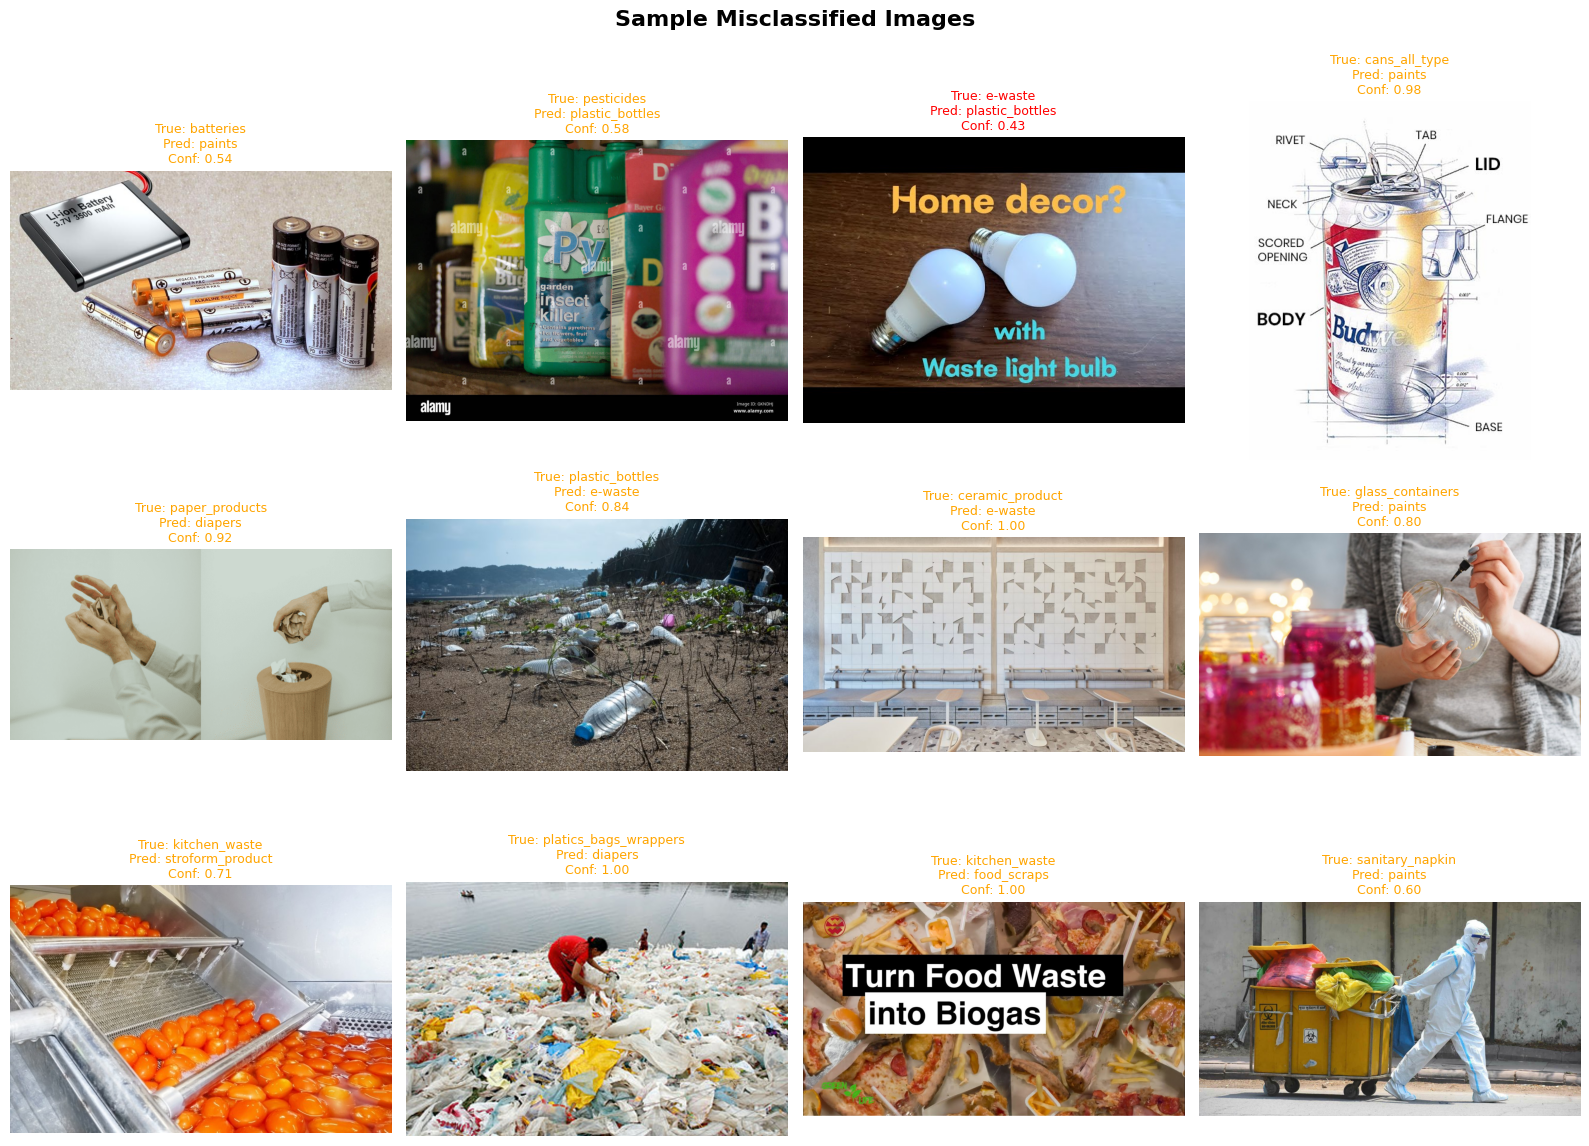


📸 Displayed 12 misclassified examples
   Red text = Low confidence (<0.5), Orange text = Medium confidence (≥0.5)


In [10]:
# Sample misclassified images
num_samples = min(12, len(misclassified_indices))
sample_indices = np.random.choice(misclassified_indices, num_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Sample Misclassified Images', fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, ax in enumerate(axes):
 if idx < len(sample_indices):
 sample_idx = sample_indices[idx]
 img_path = all_paths[sample_idx]
 true_label = label_classes[all_labels[sample_idx]]
 pred_label = label_classes[all_preds[sample_idx]]
 confidence = all_probs[sample_idx][all_preds[sample_idx]]
 
 # Load and display image
 img = Image.open(img_path).convert('RGB')
 ax.imshow(img)
 ax.axis('off')
 
 # Add labels
 ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
 fontsize=9, color='red' if confidence < 0.5 else'orange')
 else:
 ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\n Displayed {len(sample_indices)} misclassified examples")
print(" Red text = Low confidence(<0.5), Orange text = Medium confidence(≥0.5)")


### 📊 Confusion Matrix Visualization

Visualize the confusion matrix to identify misclassification patterns.


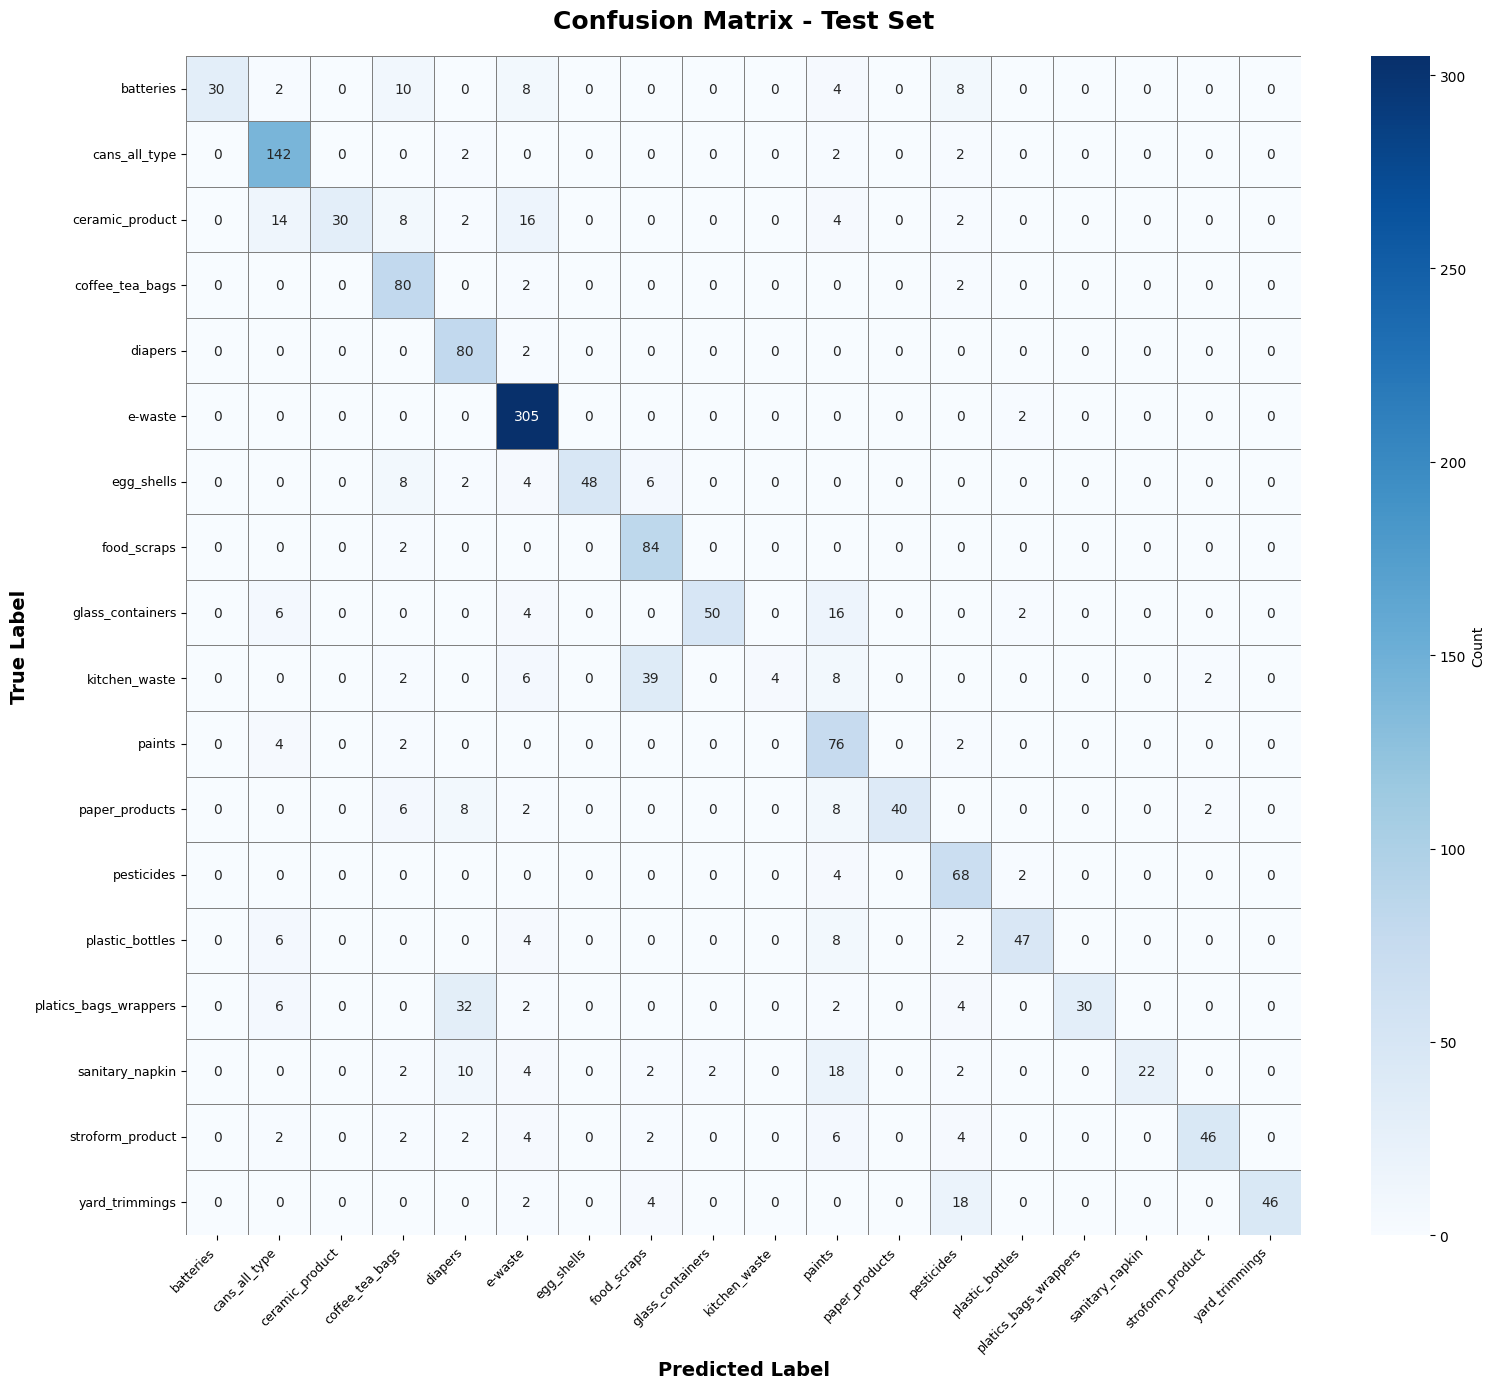

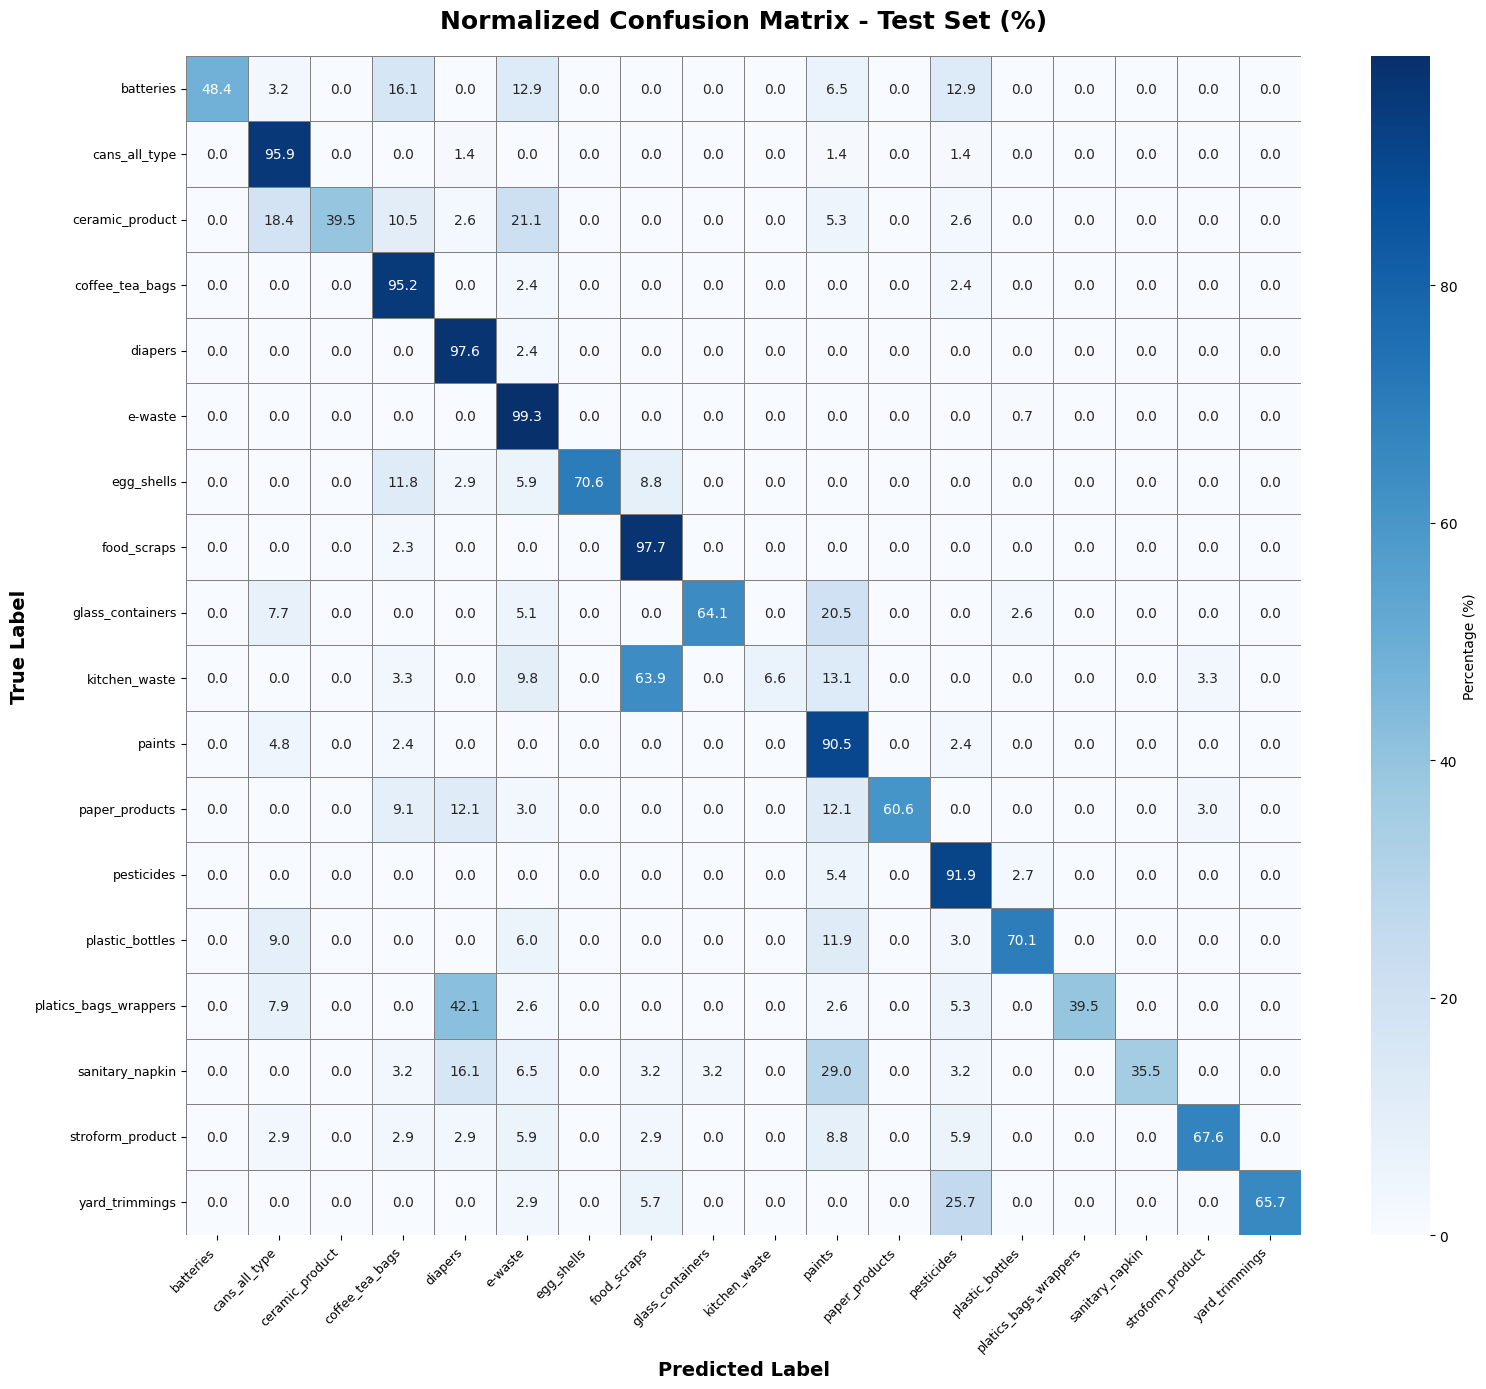

📊 Confusion matrices displayed
   - First matrix: Absolute counts
   - Second matrix: Percentages (normalized by true class)


In [11]:
# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(
 cm, 
 annot=True, 
 fmt='d', 
 cmap='Blues',
 xticklabels=label_classes,
 yticklabels=label_classes,
 cbar_kws={'label':'Count'},
 linewidths=0.5,
 linecolor='gray'
)
plt.title('Confusion Matrix - Test Set', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# Normalized confusion matrix(percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized) * 100

plt.figure(figsize=(16, 14))
sns.heatmap(
 cm_normalized, 
 annot=True, 
 fmt='.1f', 
 cmap='Blues',
 xticklabels=label_classes,
 yticklabels=label_classes,
 cbar_kws={'label':'Percentage(%)'},
 linewidths=0.5,
 linecolor='gray'
)
plt.title('Normalized Confusion Matrix - Test Set(%)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

print(" Confusion matrices displayed")
print(" - First matrix: Absolute counts")
print(" - Second matrix: Percentages(normalized by true class)")


## 📊 Category-Level Performance

Analyze performance at the category level (Hazardous, Non-Recyclable, Organic, Recyclable).


CATEGORY-LEVEL PERFORMANCE

Hazardous:
   Number of subcategories: 4
   Mean F1-Score: 0.7292 ± 0.1252
   F1-Score Range: 0.6333 - 0.9077
   Weakest class: paints (F1: 0.6333)

Non-Recyclable:
   Number of subcategories: 5
   Mean F1-Score: 0.6326 ± 0.1132
   F1-Score Range: 0.5238 - 0.7797
   Weakest class: sanitary_napkin (F1: 0.5238)

Organic:
   Number of subcategories: 5
   Mean F1-Score: 0.6548 ± 0.2984
   F1-Score Range: 0.1231 - 0.8276
   Weakest class: kitchen_waste (F1: 0.1231)

Recyclable:
   Number of subcategories: 4
   Mean F1-Score: 0.7920 ± 0.0472
   F1-Score Range: 0.7547 - 0.8606
   Weakest class: paper_products (F1: 0.7547)


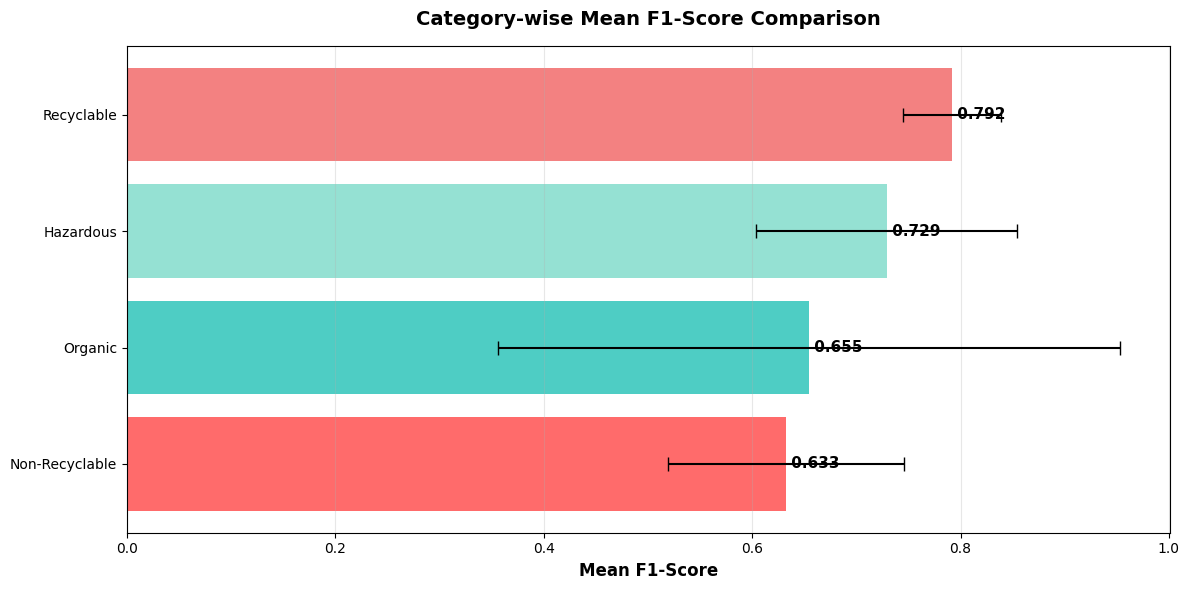

In [12]:
# Category-level analysis
category_stats = per_class_df.groupby('Category').agg({
'F1_Score': ['mean','std','min','max','count']
}).round(4)

print("=" * 80)
print("CATEGORY-LEVEL PERFORMANCE")
print("=" * 80)

for category in category_stats.index:
 stats = category_stats.loc[category]
 mean_f1 = stats[('F1_Score','mean')]
 std_f1 = stats[('F1_Score','std')]
 min_f1 = stats[('F1_Score','min')]
 max_f1 = stats[('F1_Score','max')]
 count = int(stats[('F1_Score','count')])
 
 print(f"\n{category}:")
 print(f" Number of subcategories: {count}")
 print(f" Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}")
 print(f" F1-Score Range: {min_f1:.4f} - {max_f1:.4f}")
 
 # Identify weakest class in category
 category_classes = per_class_df[per_class_df['Category'] == category]
 weakest = category_classes.loc[category_classes['F1_Score'].idxmin()]
 print(f" Weakest class: {weakest['Class']}(F1: {weakest['F1_Score']:.4f})")

# Visualize category comparison
fig, ax = plt.subplots(figsize=(12, 6))
category_means = category_stats[('F1_Score','mean')].sort_values()
category_stds = category_stats[('F1_Score','std')].loc[category_means.index]

bars = ax.barh(category_means.index, category_means.values,
 xerr=category_stds.values, capsize=5,
 color=['#FF6B6B','#4ECDC4','#95E1D3','#F38181'])
ax.set_xlabel('Mean F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Category-wise Mean F1-Score Comparison', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i,(bar, mean_f1) in enumerate(zip(bars, category_means.values)):
 ax.text(mean_f1, i, f' {mean_f1:.3f}',
 va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


## 🎯 Model Performance Summary

Create a comprehensive summary of model performance.


In [13]:
print("=" * 80)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\n Overall Metrics:")
print(f" Test Accuracy: {eval_results['test_accuracy']:.2f}%")
print(f" Weighted F1-Score: {eval_results['test_f1_weighted']:.4f}")
print(f" Macro F1-Score: {eval_results['test_f1_macro']:.4f}")

print(f"\n Per-Class Performance:")
print(f" Mean F1-Score: {per_class_df['F1_Score'].mean():.4f}")
print(f" Classes with F1 > 0.8: {(per_class_df['F1_Score'] > 0.8).sum()}")
print(f" Classes with F1 0.6-0.8: {((per_class_df['F1_Score'] >= 0.6) &(per_class_df['F1_Score'] <= 0.8)).sum()}")
print(f" Classes with F1 < 0.6: {(per_class_df['F1_Score'] < 0.6).sum()}")

print(f"\n Category Performance:")
for category in category_stats.index:
 mean_f1 = category_stats.loc[category,('F1_Score','mean')]
 print(f" {category}: {mean_f1:.4f}")

print(f"\n Classes Needing Improvement(F1 < 0.6):")
weak_classes = per_class_df[per_class_df['F1_Score'] < 0.6]
if len(weak_classes) > 0:
 for _, row in weak_classes.iterrows():
 print(f" • {row['Class']}({row['Category']}): F1 = {row['F1_Score']:.4f}")
else:
 print(" All classes performing well(F1 > 0.6)")

print(f"\n Top Performing Classes(F1 > 0.8):")
top_classes = per_class_df[per_class_df['F1_Score'] > 0.8]
if len(top_classes) > 0:
 for _, row in top_classes.iterrows():
 print(f" • {row['Class']}({row['Category']}): F1 = {row['F1_Score']:.4f}")
else:
 print(" No classes exceed 0.8 F1-score")


MODEL PERFORMANCE SUMMARY

📊 Overall Metrics:
   Test Accuracy: 75.85%
   Weighted F1-Score: 0.7387
   Macro F1-Score: 0.6956

📊 Per-Class Performance:
   Mean F1-Score: 0.6956
   Classes with F1 > 0.8: 3
   Classes with F1 0.6-0.8: 11
   Classes with F1 < 0.6: 4

📊 Category Performance:
   Hazardous: 0.7292
   Non-Recyclable: 0.6326
   Organic: 0.6548
   Recyclable: 0.7920

⚠️  Classes Needing Improvement (F1 < 0.6):
   • kitchen_waste (Organic): F1 = 0.1231
   • sanitary_napkin (Non-Recyclable): F1 = 0.5238
   • ceramic_product (Non-Recyclable): F1 = 0.5660
   • platics_bags_wrappers (Non-Recyclable): F1 = 0.5660

✅ Top Performing Classes (F1 > 0.8):
   • egg_shells (Organic): F1 = 0.8276
   • cans_all_type (Recyclable): F1 = 0.8606
   • e-waste (Hazardous): F1 = 0.9077


In [15]:
print("=" * 80)
print("RECOMMENDATIONS FOR MODEL IMPROVEMENT")
print("=" * 80)

# Identify weak classes
weak_classes = per_class_df[per_class_df['F1_Score'] < 0.6]
minority_classes = ['batteries','sanitary_napkin','kitchen_waste','stroform_product','paper_products','egg_shells']

print(f"\n Analysis:")
print(f" Classes with F1 < 0.6: {len(weak_classes)}")
print(f" Check if weak classes overlap with minority classes")

if len(weak_classes) > 0:
 print(f"\n Recommendations for Weak Classes:")
 for _, row in weak_classes.iterrows():
 class_name = row['Class']
 f1 = row['F1_Score']
 is_minority = class_name in minority_classes
 
 print(f"\n • {class_name}(F1: {f1:.4f}):")
 if is_minority:
 print(f" - Already a minority class - increase augmentation factor")
 print(f" - Consider collecting more training data")
 print(f" - Review confusion matrix for misclassification patterns")
 print(f" - Check if class is confused with similar-looking classes")
 print(f" - Consider class-specific data augmentation strategies")

# Category-level recommendations
print(f"\n Category-Level Recommendations:")
for category in category_stats.index:
 mean_f1 = category_stats.loc[category,('F1_Score','mean')]
 if mean_f1 < 0.6:
 print(f" • {category}: Low performance - review category-specific preprocessing")
 elif mean_f1 < 0.75:
 print(f" • {category}: Moderate performance - fine-tune category-specific features")

# General recommendations
print(f"\n General Recommendations:")
if eval_results['test_f1_macro'] < 0.6:
 print(" 1. Model needs significant improvement - consider:")
 print(" - Trying different architectures(EfficientNet, Vision Transformer)")
 print(" - Increasing model capacity")
 print(" - More aggressive data augmentation")
 print(" - Collecting more training data")
elif eval_results['test_f1_macro'] < 0.75:
 print(" 1. Model performance is acceptable but can be improved:")
 print(" - Fine-tune hyperparameters")
 print(" - Try ensemble methods")
 print(" - Focus on improving weak classes")
else:
 print(" 1. Model performance is good - consider:")
 print(" - Fine-tuning for deployment optimization")
 print(" - Creating ensemble models for better accuracy")

print("\n 2. For classes with low F1-scores:")
print(" - Review confusion matrix to identify confusion patterns")
print(" - Collect more diverse training samples")
print(" - Apply class-specific augmentation")
print(" - Consider hierarchical classification approach")

print("\n 3. For deployment:")
print(" - Test model on real-world images")
print(" - Monitor model performance in production")
print(" - Implement confidence thresholds")
print(" - Create fallback mechanisms for low-confidence predictions")


RECOMMENDATIONS FOR MODEL IMPROVEMENT

🔍 Analysis:
   Classes with F1 < 0.6: 4
   Check if weak classes overlap with minority classes

⚠️  Recommendations for Weak Classes:

   • kitchen_waste (F1: 0.1231):
     - Already a minority class - increase augmentation factor
     - Consider collecting more training data
     - Review confusion matrix for misclassification patterns
     - Check if class is confused with similar-looking classes
     - Consider class-specific data augmentation strategies

   • sanitary_napkin (F1: 0.5238):
     - Already a minority class - increase augmentation factor
     - Consider collecting more training data
     - Review confusion matrix for misclassification patterns
     - Check if class is confused with similar-looking classes
     - Consider class-specific data augmentation strategies

   • ceramic_product (F1: 0.5660):
     - Review confusion matrix for misclassification patterns
     - Check if class is confused with similar-looking classes
     - C

## 📋 Summary

### Key Findings (Interpret from outputs above)
- **Overall Performance**: Review test accuracy and F1-scores from evaluation results
- **Class Balance**: Check if minority classes perform worse than majority classes
- **Category Performance**: Identify which categories need improvement
- **Training Quality**: Analyze training history for overfitting signs

### Next Steps
1. **Error Analysis**: After training completes, analyze specific misclassifications
2. **Model Refinement**: Apply recommendations to improve weak classes
3. **Inference Pipeline**: Create inference script for real-world predictions
4. **Deployment**: Prepare model for production deployment

---

## 🎯 Notes

### Performance Metrics Interpretation
- **Accuracy**: Overall correctness, but can be misleading with imbalanced data
- **Weighted F1**: Accounts for class imbalance - good overall metric
- **Macro F1**: Treats all classes equally - important for minority classes
- **Per-Class F1**: Identifies specific classes needing improvement

### Evaluation Insights
- Compare validation and test metrics to check generalization
- Analyze confusion matrix for misclassification patterns
- Review per-class performance, especially safety-critical classes
- Check if training converged properly (training history plots)

### Model Improvement Strategy
- Focus on classes with F1 < 0.6 first
- Consider if weak classes correlate with minority classes
- Review category-level performance for patterns
- Plan data collection or augmentation for weak classes
